# Human Activity Recognition Using Smartphones

The Human Activity Recognition database is built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.

The goal of the Final Project is to predict the type of activity of the subject from the inertial sensor data recorded from the waist-mounted smartphones 

In [4]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report

## Get the Training and Test Data

In [5]:
# get the features
feature_file = 'data/features.txt'

features = []
with open(feature_file, 'r') as file:
    for line in file:
        columns = line.split()
        features.append(columns[1])

print('No. of Features: {}'.format(len(features)))


No. of Features: 561


In [6]:
# create a list of unique features by appending 'n' at the end of the feature till the 
# length of the unique feature list matches that of the original list of features

seen = set()
uniq_features = []
for idx, x in enumerate(features):
    if x not in seen:
        uniq_features.append(x)
        seen.add(x)
    elif x + 'n' not in seen:
        uniq_features.append(x + '_')
        seen.add(x + 'n')
    else:
        uniq_features.append(x + '__')
        seen.add(x + 'nn')
print("Length of unique features = " + str(len(uniq_features)))


Length of unique features = 561


In [7]:
# get the training data from txt files to pandas dataffame
X_train = pd.read_csv('data/train/X_train.txt', delim_whitespace=True, header=None, names=uniq_features)

# # add subject column to the dataframe
X_train['subject'] = pd.read_csv('data/train/subject_train.txt', header=None)

y_train = pd.read_csv('data/train/y_train.txt', names=['Activity'])

def map_labels(value):
    label_map = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}
    return label_map[value]

y_train_labels = y_train.map(map_labels)

# put all columns in a single dataframe
train = X_train.copy()
train['Activity'] = y_train.copy()
train['ActivityName'] = y_train_labels.copy()
train.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
376,0.281392,-0.012365,-0.104879,-0.997786,-0.994403,-0.994121,-0.998222,-0.993674,-0.993918,-0.940746,...,-0.016645,0.63111,0.849074,0.042488,-0.680101,0.309099,-0.048842,3,5,STANDING


In [8]:
# get the test data from txt files to pandas dataffame
X_test = pd.read_csv('data/test/X_test.txt', delim_whitespace=True, header=None, names=uniq_features)

# # add subject column to the dataframe
X_test['subject'] = pd.read_csv('data/test/subject_test.txt', header=None)

y_test = pd.read_csv('data/test/y_test.txt', names=['Activity'])

def map_labels(value):
    label_map = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}
    return label_map[value]

y_test_labels = y_test.map(map_labels)

# put all columns in a single dataframe
test = X_test.copy()
test['Activity'] = y_test.copy()
test['ActivityName'] = y_test_labels.copy()
test.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
1079,0.280328,-0.016061,-0.107867,-0.997706,-0.997745,-0.992364,-0.998055,-0.996998,-0.992983,-0.939527,...,-0.144945,0.428751,-0.661007,0.012514,-0.331231,0.491103,-0.20709,10,4,SITTING


## Data Check

Check for duplicate and nan/null values in the test and training data

In [9]:
train_duplicate = sum(train.duplicated())
test_duplicate  = sum(test.duplicated())
train_null = train.isnull().values.sum()
test_null  = test.isnull().values.sum()

print("Duplicates in training set = " + str(train_duplicate))
print("Duplicates in test set = " + str(test_duplicate))
print("Nulls in training set = " + str(train_null))
print("Nulls in test set = " + str(test_null))

Duplicates in training set = 0
Duplicates in test set = 0
Nulls in training set = 0
Nulls in test set = 0


## Renaming Data Columns

In [10]:
columns = train.columns

# Removing '()' from column names
columns = columns.str.replace('()','')
columns = columns.str.replace('-', '')
columns = columns.str.replace(',','')

train.columns = columns
test.columns = columns

## Statistical Analysis

In the following cell, we look at a small slice of the data to gain some insight.

Here we calculate the mean value of the first 12 columns of the training dataset grouped by the activity names. We observe that the walking, walking upstairs and walking downstairs can be differentiated from the rest by tBodyAccstdX, tBodyAccstdY and tBodyAccstdZ. The mean value of tBodyAccmaxX shows that all the walking modes can also be differentiated between each other.

In [33]:
grouped = train.groupby('ActivityName')

mean_values = grouped.mean()
for i in range(12):
    col = mean_values.iloc[:,i]
    print(col)
    print('')

ActivityName
LAYING                0.269191
SITTING               0.273449
STANDING              0.279294
WALKING               0.276260
WALKING_DOWNSTAIRS    0.288169
WALKING_UPSTAIRS      0.261930
Name: tBodyAccmeanX, dtype: float64

ActivityName
LAYING               -0.018345
SITTING              -0.012143
STANDING             -0.016123
WALKING              -0.017768
WALKING_DOWNSTAIRS   -0.016370
WALKING_UPSTAIRS     -0.026647
Name: tBodyAccmeanY, dtype: float64

ActivityName
LAYING               -0.107169
SITTING              -0.106581
STANDING             -0.107330
WALKING              -0.108884
WALKING_DOWNSTAIRS   -0.105860
WALKING_UPSTAIRS     -0.120424
Name: tBodyAccmeanZ, dtype: float64

ActivityName
LAYING               -0.959475
SITTING              -0.983450
STANDING             -0.985346
WALKING              -0.312641
WALKING_DOWNSTAIRS    0.139847
WALKING_UPSTAIRS     -0.221072
Name: tBodyAccstdX, dtype: float64

ActivityName
LAYING               -0.937609
SITTING      

## Visualizing the Data

In the cell below, we create 2D plots of a slice of the data. 

We plot the data in successive columns for the first 9 columns. We observe that some of the data can be separated based on the tBodyAccstd-X,Y,Z and tBodyAccmad-X,Y,Z data. 

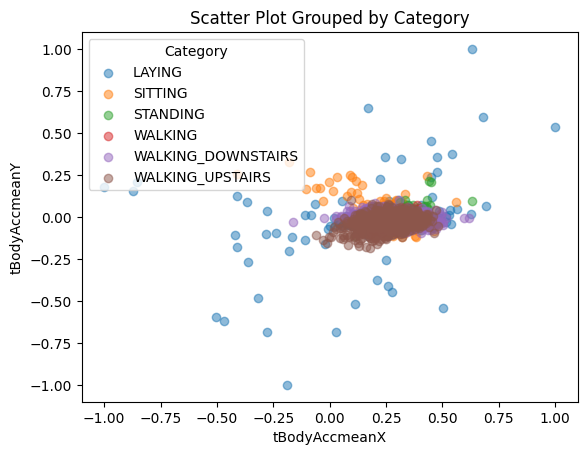

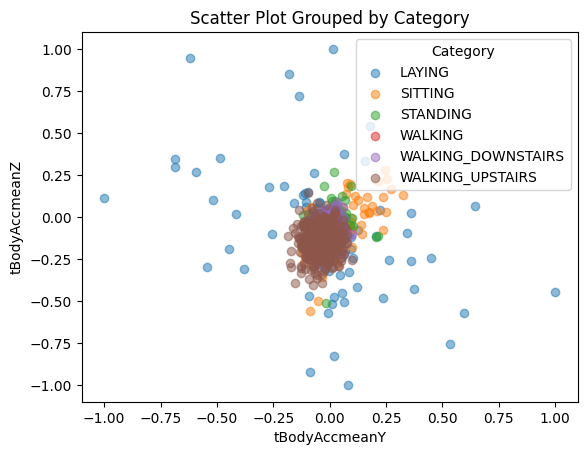

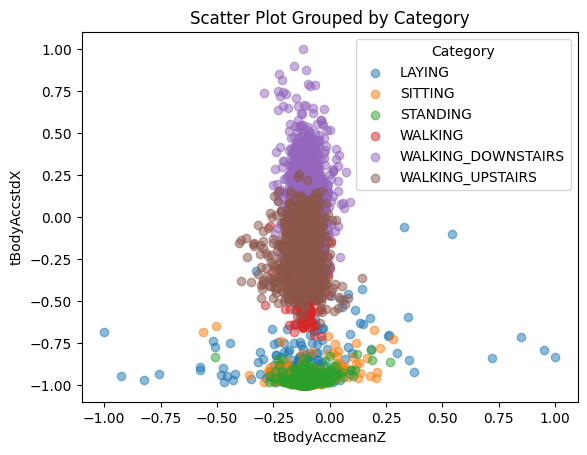

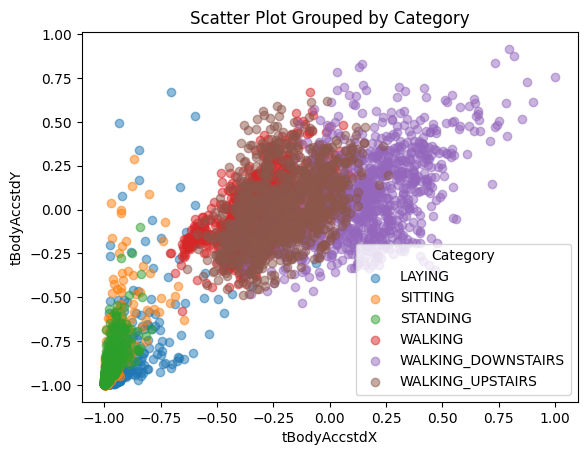

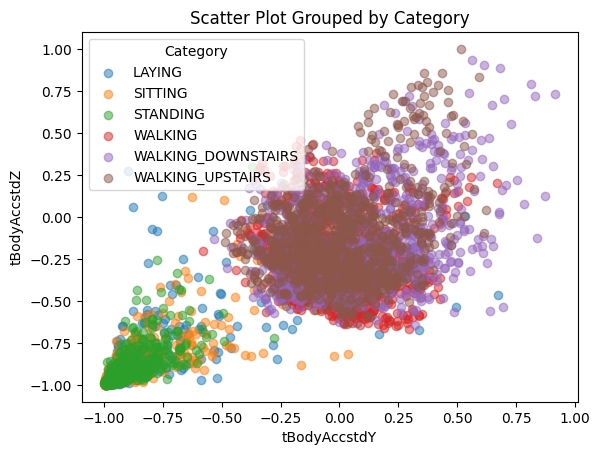

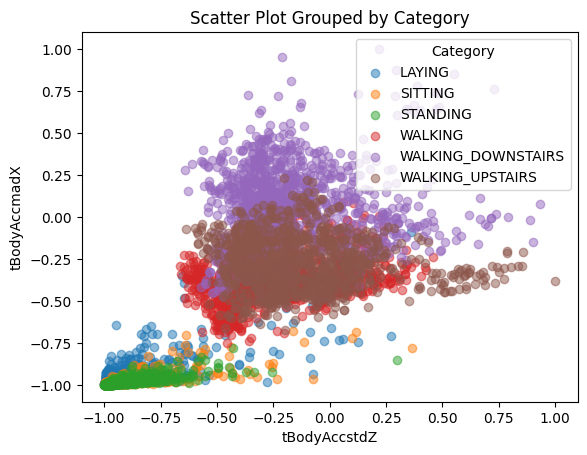

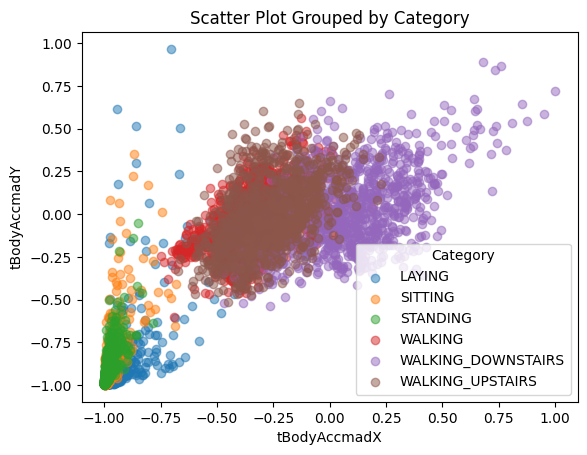

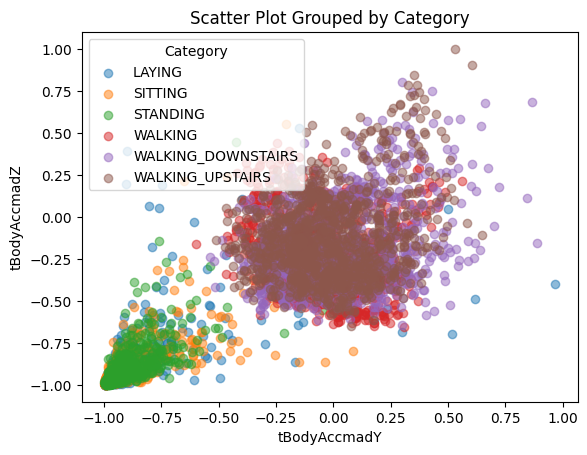

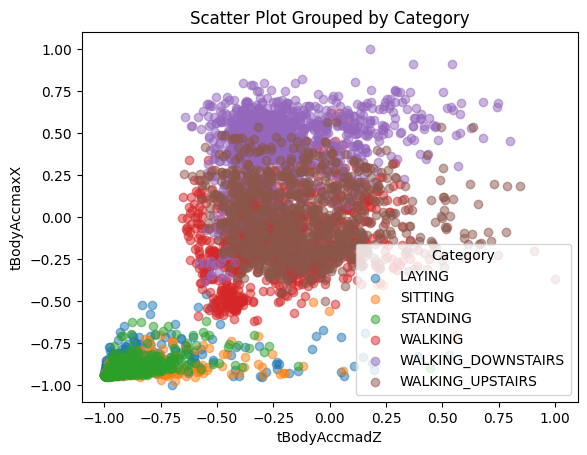

In [29]:
column_names = train.columns

for i in range(9):
    for name, group in grouped:
        colx = column_names[i]
        coly = column_names[i+1]
        plt.figure(i)
        plt.scatter(group[colx], group[coly], label=name, alpha = 0.5)
        plt.xlabel(colx)
        plt.ylabel(coly)
        plt.title('Scatter Plot Grouped by Category')
        plt.legend(title='Category')
   

<Axes: xlabel='ActivityName', ylabel='count'>

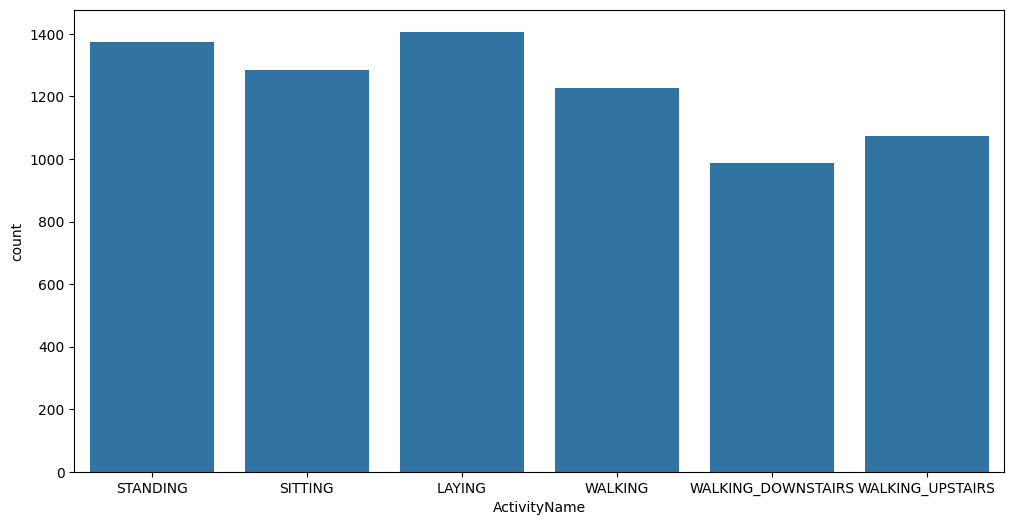

In [30]:
## Create frequency plot of activity labels

plt.figure(figsize=(12,6))
sns.countplot(x=train['ActivityName'])

## Classification
### Support Vector Machine Classifier

In [12]:
# SVC
svc = SVC(random_state=42)
svc.fit(X_train, y_train)

# Predict
y_pred = svc.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred)
print(report)

/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           1       0.90      1.00      0.94       496
           2       0.94      0.95      0.94       471
           3       0.99      0.85      0.92       420
           4       0.90      0.86      0.88       491
           5       0.88      0.92      0.90       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

